### Numerical Experiments

6 different datasets are used with ids [31, 1464, 334, 333, 1504]
The different optimizers for sparse grid optimization are compared

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

BUDGET = 50
VERBOSE = 0
CV = 2
SCORING = 'neg_mean_squared_error'
TESTING = False

DATASETS = []


2023-04-13 09:56:18.254160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 09:56:19.546388: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
hyperparameterspace = {
    'loss': ["list", 'mean_absolute_error', 'mean_squared_error'],
    'epochs': ["interval-int", 1, 50],
    'batch_size': ["interval-int", 40, 160],
    'optimizer': ["list", 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    'optimizer__learning_rate': ["interval", 0.0000001, 0.01]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [3]:
ids = [233214, 233211, 359935]#, 359952, 359940, 359931, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x, max_value=250)

ACTIVATION_FUNCTION = relu_advanced


RESULTS_datasets = [[] for _ in range(len(ids))]

valid_datasets = 0
for i in range(len(ids)):

    DATASETS.append(str(ids[i]))
    
    task = tasks.get_task(ids[i])

    # Get dataset by ID
    dataset = task.get_dataset()

    print("Current dataset:", i, "of", len(ids), "with name:", dataset.name)

    # Get the data itself as a dataframe (or otherwise)
    data, target, _, _ = dataset.get_data(dataset.default_target_attribute, dataset_format="array")
    if np.isnan(data).any() or np.isnan(target).any():
        print("NaN detected, skipping dataset")
        continue

    X = torch.Tensor(data[:1000])
    Y = torch.Tensor(target[:1000])

    dataset = HPO.Dataset(X, Y)

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = hyperparameterspace_special["loss"][index]
            
            epochs = int(from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[1]))

            batch_size = int(from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[2]))

            index = int(x[3]*(len(hyperparameterspace_special["optimizer"])-1))
            model_optimizer = hyperparameterspace_special["optimizer"][index]

            model_learning_rate = from_standard(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[4])
            
            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
                model.add(BatchNormalization())
                model.add(Dense(20, activation=ACTIVATION_FUNCTION))
                model.add(BatchNormalization())
                model.add(Dense(1, activation=ACTIVATION_FUNCTION))
                # Compile model
                if model_optimizer == 'SGD':
                    optimizer = keras.optimizers.SGD(learning_rate=model_learning_rate)
                elif model_optimizer == 'RMSprop':
                    optimizer = keras.optimizers.RMSprop(learning_rate=model_learning_rate)
                elif model_optimizer =='Adagrad':
                    optimizer = keras.optimizers.Adagrad(learning_rate=model_learning_rate)
                elif model_optimizer =='Adadelta':
                    optimizer = keras.optimizers.Adadelta(learning_rate=model_learning_rate)
                elif model_optimizer =='Adam':
                    optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)
                elif model_optimizer =='Adamax':
                    optimizer = keras.optimizers.Adamax(learning_rate=model_learning_rate)
                elif model_optimizer == 'Nadam':
                    optimizer = keras.optimizers.Nadam(learning_rate=model_learning_rate)

                model.compile(loss=loss, optimizer=optimizer,)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
              

    available_optimizers = ["adaptive_gradient_descent", "adaptive_newton", "bfgs", "differential_evolution", "gradient_descent", "nlcg", "nelder_mead", "newton", "rprop"] # "cmaes", 

    results_temp = []
    results_opt_temp = []

    for j in range(len(available_optimizers)):
        print("Current optimizer:", j, available_optimizers[j])

        sparse_params=[2, 0.95, available_optimizers[j]]

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=sparse_params[0], adaptivity=sparse_params[1], optimizer=sparse_params[2])

        result = optimization.fit()


        TESTING = True
        results_temp.append(f.eval(result[0]))
        results_temp.append(f.eval(result[1]))
        TESTING = False

    for m in range(len(results_temp)):
        RESULTS_datasets[i].append(results_temp[m])


Current dataset: 0 of 3 with name: Santander_transaction_value
Current optimizer: 0 adaptive_gradient_descent
Adaptive grid generation (Ritter-Novak)...


2023-04-13 09:56:24.165163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-13 09:56:24.166592: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Done in 137040ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 1ms.
Current optimizer: 1 adaptive_newton
Adaptive grid generation (Ritter-Novak)...
Done in 121169ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive Newton)...
Done in 1ms.
Current optimizer: 2 bfgs
Adaptive grid generation (Ritter-Novak)...
Done in 127070ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (BFGS)...
Done in 0ms.
Current optimizer: 3 differential_evolution
Adaptive grid generation (Ritter-Novak)...
Done in 127069ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (differential evolution)...
Done in 2ms.
Current optimizer: 4 gradient_descent
Adaptive grid generation (Ritter-Novak)...
Done in 133498ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current optimizer: 5 nlcg
Adaptive grid generation (Ritter-Novak)...
Done in

### Plotting

[[107527719437422.8, 107526268631441.19, 107527749887657.77, 107528021422620.62, 107528328447574.02, 107529368791241.45, 107527403787874.08, 107526363196398.16, 107527989111109.9, 107527055985181.08, 107527907396521.12, 107528554903263.72, 107527921974721.48, 107526268631441.19, 107527400120914.98, 107527987793622.42, 107527318202643.02, 107529469581087.4], [6009476.77005795, 6890239.61986292, 5941032.24, 7044713.657930289, 6590415.934715492, 6771864.785357223, 6664308.586601282, 6408674.078953764, 6975714.73599539, 6864694.979808051, 6364490.715489678, 7163776.639790139, 7090146.40631983, 6105102.045766091, 7124086.979027577, 7004752.387861579, 5941032.24, 7164577.24], [24.984966986432884, 29.43828530153022, 62.88347035865162, 30.85495886880024, 1.5594766110220473, 1.1759649432953097, 0.704939967882101, 0.87619955883172, 7.217412260513114, 10.529551349751364, 9.181685380084962, 21.938913823923517, 2.498582398007152, 1.182955937095977, 17.37567995659107, 15.470011799080371, 4.940900137

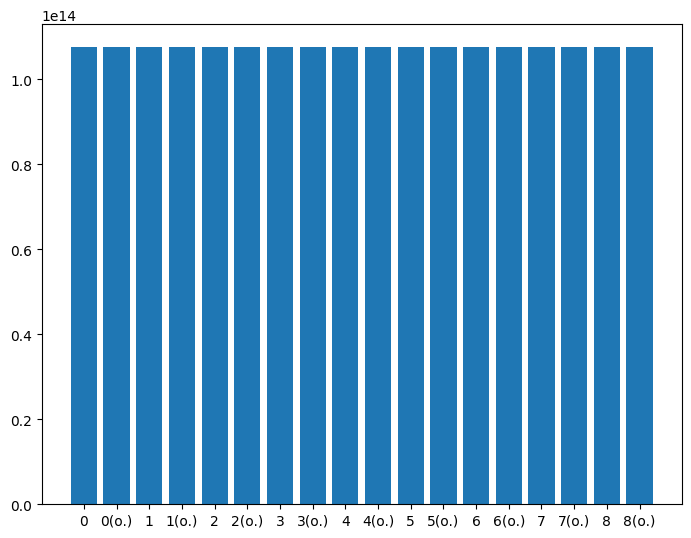

Dataset with id 233211


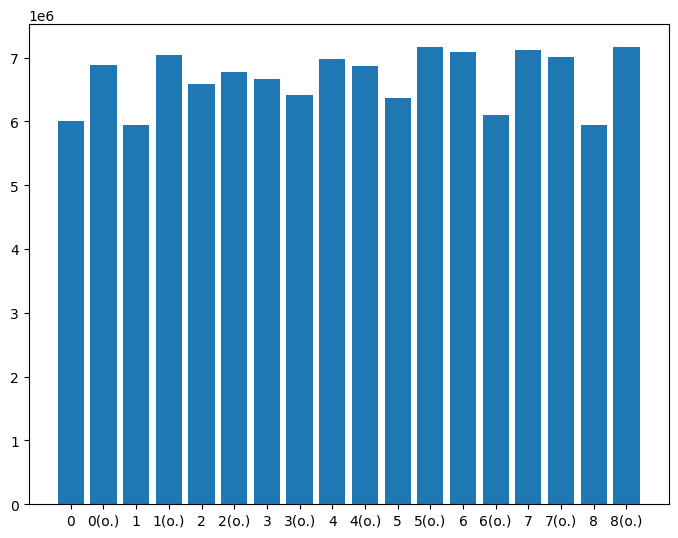

Dataset with id 359935


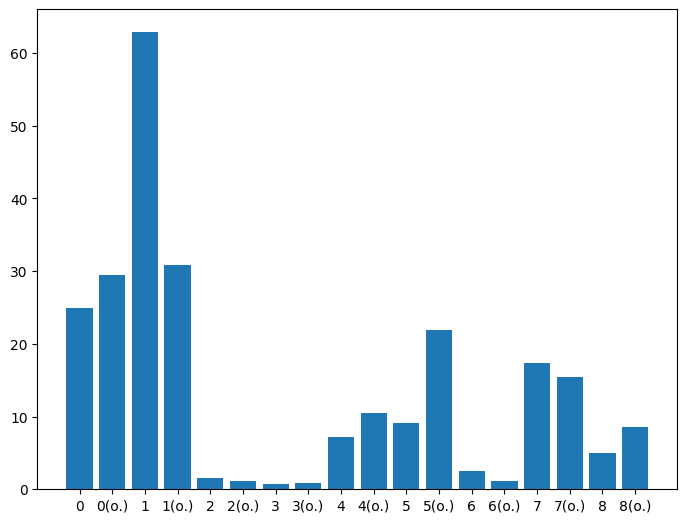

In [4]:

print(RESULTS_datasets)

for i in range(len(ids)):
    print("Dataset with id", ids[i])

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    opts = []
    k = 0
    for optimizer_name in available_optimizers:
        opts.append(str(k))
        opts.append(str(k) + "(o.)")
        k += 1

    ax.bar(opts, RESULTS_datasets[i])
    plt.show()

